In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Dense, Dropout, Flatten
)
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from load_data import unpickle

In [2]:
plt.style.use('ggplot')

In [3]:
def get_filename(file_num):
    """Get the filename of a CIFAR-10 data batch
    
    Args:
        file_num (int): batch number
        
    Returns:
        filename (str): name of CIFAR-10 data batch
    """
    
    filename = 'data/data_batch_{0}'.format(file_num)
    return filename

def get_inputs(is_test_input=False):
    """Get the inputs from the CIFAR-10 data batches
    
    Args:
        is_test_input (bool): 
            specifies whether or not the inputs are test inputs
    
    Returns:
        X (numpy array): (N, 32, 32, 3) representation of images
        y (numpy array): one-hot encoded image labels
    """
    
    if (is_test_input):    
        batch = unpickle('data/test_batch')
        X, y = batch[b'data'], np.array(batch[b'labels'])
    else:
        files = [get_filename(file_num) for file_num in range(1, 6)]
        batches = [unpickle(file) for file in files]

        data = [batches[i][b'data'] for i in range(0, 5)]
        labels = [batches[i][b'labels'] for i in range(0, 5)]

        X, y = np.concatenate(data), np.concatenate(labels)
    
    X, y = X.reshape(X.shape[0], 32, 32, 3), to_categorical(y)
    X = X / 255
    return X, y

In [4]:
X, y = get_inputs()
X_test, y_test = get_inputs(is_test_input=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [ ]:
nadam_optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.005, 
    beta_1=0.9, 
    beta_2=0.999
)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=nadam_optimizer, 
    metrics=['categorical_accuracy']
)

In [43]:
model.summary()

In [45]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=256,
    epochs=10, 
    validation_data=(X_val, y_val)
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 106s 3ms/sample - loss: 1.3587 - categorical_accuracy: 0.5344 - val_loss: 1.7157 - val_categorical_accuracy: 0.4269
Epoch 2/10
40000/40000 [==============================] - 111s 3ms/sample - loss: 1.1502 - categorical_accuracy: 0.6080 - val_loss: 1.6273 - val_categorical_accuracy: 0.4613
Epoch 3/10
40000/40000 [==============================] - 113s 3ms/sample - loss: 1.0787 - categorical_accuracy: 0.6308 - val_loss: 1.3225 - val_categorical_accuracy: 0.5506
Epoch 4/10
40000/40000 [==============================] - 113s 3ms/sample - loss: 1.0255 - categorical_accuracy: 0.6503 - val_loss: 1.3168 - val_categorical_accuracy: 0.5526
Epoch 5/10
40000/40000 [==============================] - 110s 3ms/sample - loss: 0.9876 - categorical_accuracy: 0.6639 - val_loss: 1.4513 - val_categorical_accuracy: 0.5345
Epoch 6/10
40000/40000 [==============================] - 114s 3ms/sample - loss

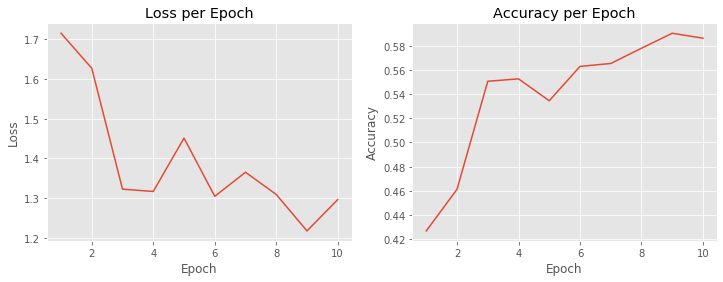

10000/10000 [==============================] - 3s 321us/sample - loss: 1.2854 - categorical_accuracy: 0.5843

Test result: 0.5843 loss: 1.2854


In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes = axes.flatten()

loss = sns.lineplot(
    x=np.arange(1, 11), 
    y=history.history['val_loss'], 
    ax=axes[0]
)
loss.set(title="Loss per Epoch", xlabel="Epoch", ylabel="Loss")

accuracy = sns.lineplot(
    x=np.arange(1, 11), 
    y=history.history['val_categorical_accuracy'], 
    ax=axes[1]
)
accuracy.set(title="Accuracy per Epoch", xlabel="Epoch", ylabel="Accuracy")
plt.show()

scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.4f loss: %.4f' % (scores[1], scores[0]))